## make sure you have all libraries installed. 
use conda environment: /scratch/da2734/twitter/worldbank_twitter_environment.yml

In [1]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

# LOG_PATH=Path('/scratch/da2734/twitter/sana/log/')
# DATA_PATH=Path('/scratch/da2734/twitter/sana/data')
# LABEL_PATH=Path('/scratch/da2734/twitter/sana/data/')
# OUTPUT_PATH=Path('/scratch/da2734/twitter/sana/output/')
LOG_PATH=Path('/scratch/da2734/twitter/mturk_mar6/log/')
DATA_PATH=Path('/scratch/da2734/twitter/mturk_mar6/data')
LABEL_PATH=Path('/scratch/da2734/twitter/mturk_mar6/data/')
OUTPUT_PATH=Path('/scratch/da2734/twitter/mturk_mar6/output_100')
FINETUNED_PATH = None

args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "labor_market_classification",
    "no_cuda": False,
#     "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 200,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-uncased',
    "model_type": 'bert'
})

import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

# logger.info(args)

device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

label_cols = ["job_loss","is_unemployed","job_search","is_hired","job_offer"]

# databunch defined here https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
databunch = BertDataBunch(
                        args['data_dir'], 
                        LABEL_PATH, 
                        args.model_name, 
                        train_file='train.csv', 
                        val_file='val.csv',
                        # test_data='test.csv',
                        text_col="text", #this is the name of the column in the train file that containts the tweet text
                        label_col=label_cols,
                        batch_size_per_gpu=args['train_batch_size'], 
                        max_seq_length=args['max_seq_length'], 
                        multi_gpu=args.multi_gpu, 
                        multi_label=True, 
                        model_type=args.model_type)

num_labels = len(databunch.labels)
print('num_labels', num_labels)

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device)

# metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'roc_auc_save_to_plot', 'function': roc_auc_save_to_plot})
metrics.append({'name': 'fbeta', 'function': fbeta})
metrics.append({'name': 'accuracy', 'function': accuracy})
metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})


learner = BertLearner.from_pretrained_model(
                                            databunch, 
                                            pretrained_path='/scratch/da2734/twitter/mturk_mar6/output_100/model_out/', 
                                            metrics=metrics, 
                                            device=device, 
                                            logger=logger, 
                                            output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, 
                                            warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, 
                                            is_fp16=args.fp16, 
                                            multi_label=True, 
                                            logging_steps=0)

print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')



/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


03/10/2020 12:37:13 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/da2734/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/10/2020 12:37:13 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data/cache/cached_bert_train_multi_label_512_train.csv
03/10/2020 12:37:14 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data/cache/cached_bert_dev_multi_label_512_val.csv
num_labels 5
__Python VERSION: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
03/10/2020 12:37:14 - INFO - transformers.configuration_utils -   loading configuration file /scratch/da2734/twi

# loading random and filtered samples

In [ ]:
# filtered contains 8G of data!!
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/classification/US/filtered/'
tweets_filtered=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
#                                            country_code,
#                                            month,
                                           '*.parquet'))).read().to_pandas()
print('time taken to load keyword filtered sample:', str(time.time() - start_time), 'seconds')
print(tweets_filtered.shape)

In [1]:
# random contains 7.3G of data!!
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/classification/US/random'
tweets_random=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
#                                            country_code,
#                                            month,
                                           '*.parquet'))).read().to_pandas()
print('time taken to load random sample:', str(time.time() - start_time), 'seconds')
print(tweets_random.shape)

time taken to load all this stuff: 75.89868831634521 seconds


## converting tweets to list of strings

In [ ]:
start_time = time.time()
texts_filtered = tweets_filtered['text'].values.tolist()
texts_random   = tweets_random['text'].values.tolist()
print('time taken:', str(time.time() - start_time), 'seconds') 

In [ ]:
def time_per_tweet(num_tweets):
    start_time = time.time()
#     num_tweets = 1000
    # texts = ['I just received a job offer']
    texts = tweets['text'][:num_tweets].values.tolist()
    # print(texts)
    predictions = learner.predict_batch(texts)
    # i = 3
    # print(texts[i], predictions[i])
    time_taken = time.time() - start_time
    print('total inference time:', time_taken, 'seconds')
    print('per tweet:', time_taken/num_tweets, 'seconds')
    return {'num_tweets': num_tweets, 'total': time_taken, 'pertweet': time_taken/num_tweets}

results = pd.DataFrame()
for i in range(6):
    print(1*(10**i), 'tweets running..')
    results = results.append(time_per_tweet(1*(10**i)), 
                             ignore_index=True)

print(results)

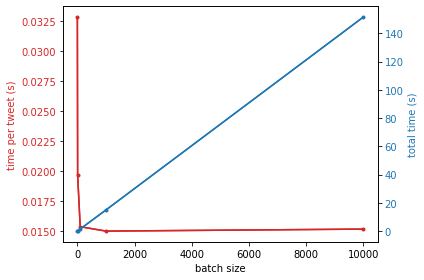

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch size')
ax1.set_ylabel('time per tweet (s)', color=color)
ax1.plot(results["num_tweets"], results["pertweet"], color=color, marker='.')
ax1.plot(results["num_tweets"], results["pertweet"], color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(results["num_tweets"], results["total"], color=color, marker='.')
ax2.plot(results["num_tweets"], results["total"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()